# Predicting the Severity of Road Traffic Accidents

https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall

## Table of contents
* [Introduction: Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Problem

Traffic accidents are a significant source of deaths, injuries, property damage, and a major concern for public health and traffic safety. Accidents are also a major cause of traffic congestion and delay. Effective management of accident is crucial to mitigating accident impacts and improving traffic safety and transportation system efficiency. Accurate predictions of severity can provide crucial information for emergency responders to **evaluate the severity level of accidents, locate accident blackspots, estimate the potential impacts, and implement efficient accident management procedures**.

Model can be applied to predictions of accident severity which is an essential step in accident management process. By recognizing those key influences, this report can provide suggestive results for **government and local authorities** to take effective measures to reduce accident impacts and improve traffic safety.

## Data

Dataset includes detailed information about collisions provided by Seattle Police Department and recorded by Traffic Records.

Based on definition of our problem, factors that will be taken into consideration for our predictions are:
* location of the collision to look out black spots
* weather, light and road conditions
* speeding, driving under influence and inattentive driving 
* address and junction type
* number of persons, pedestrians, bicycles and vehicles involved into incident
* some other

In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Loading Data from CSV file

In [492]:
df = pd.read_csv('Data-Collisions.csv')

C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [493]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [494]:
df.shape

(194673, 38)

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

Let's see how many of each class is in our data set

In [496]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

136485 incidents ended with **property damage** and 58188 involved **injury**. Our dataset is **imbalanced**.

## Data visualization and pre-processing

### Review and fill up missing values first

#### Let's count number of Null values in each column

In [497]:
df.isnull().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE            1926
INTKEY            129603
LOCATION            2677
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SDOTCOLNUM         79737
SPEEDING          185340
ST_COLCODE            18
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

#### All missing values that we are interested in are categorical type. Some missing values will be replaced with mode, another - with 'Unknown' status, the rest will be converted from categorical to numeric values

In [498]:
def nan_to_max_occ(item):
    df.loc[df[item].isnull(), [item]] = df[item].value_counts().idxmax()

In [499]:
def nan_to_unknown(item):    
    df.loc[df[item].isnull(), [item]] = 'Unknown'

In [500]:
def nan_to_numeric(item):
    df.loc[df[item].isnull(), item] = 0
    df.loc[df[item] == 'N', item] = 0
    df.loc[df[item] == 'Y', item] = 1

In [501]:
for item in ['ADDRTYPE', 'COLLISIONTYPE', 'SDOT_COLCODE']:
    nan_to_max_occ(item)

In [502]:
for item in ['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']:
    nan_to_unknown(item)

In [503]:
for item in ['INATTENTIONIND', 'SPEEDING', 'HITPARKEDCAR', 'PEDROWNOTGRNT']:
    nan_to_numeric(item)

In [504]:
df['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [505]:
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace=[np.nan, 'N', '0', 'Y', '1'], value=[0, 0, 0, 1, 1])

In [506]:
df['UNDERINFL'].value_counts()

0    185552
1      9121
Name: UNDERINFL, dtype: int64

In [507]:
df.isnull().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE               0
INTKEY            129603
LOCATION            2677
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE          0
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE           0
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER                0
ROADCOND               0
LIGHTCOND              0
PEDROWNOTGRNT          0
SDOTCOLNUM         79737
SPEEDING               0
ST_COLCODE            18
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

In [508]:
df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
0          1               0.705603
           2               0.294397
1          1               0.609473
           2               0.390527
Name: SEVERITYCODE, dtype: float64

In [510]:
df['INCDATE'] = pd.to_datetime(df['INCDATE'])

In [511]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

In [512]:
df['INCDTTM'].head()

0   2013-03-27 14:54:00
1   2006-12-20 18:55:00
2   2004-11-18 10:20:00
3   2013-03-29 09:26:00
4   2004-01-28 08:04:00
Name: INCDTTM, dtype: datetime64[ns]

In [513]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,0,NaN,0,10,Entering at angle,0,0,0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,0,6354039.0,0,11,From same direction - both going straight - bo...,0,0,0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,0,4323031.0,0,32,One parked--one moving,0,0,0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,0,NaN,0,23,From same direction - all others,0,0,0
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,0,4028032.0,0,10,Entering at angle,0,0,0


### Let's review outliers for numeric features 

#### Number of persons involved in the collision with severity type:

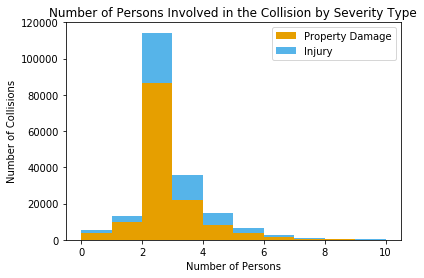

In [514]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PERSONCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PERSONCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 10], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Persons')
plt.ylabel('Number of Collisions')
plt.title('Number of Persons Involved in the Collision by Severity Type');

In [515]:
df.loc[df['PERSONCOUNT'] > 10, 'PERSONCOUNT']

93        16
639       11
966       12
1124      11
1650      17
3594      26
4073      22
4655      37
5083      12
6452      13
6766      13
6787      36
6798      28
7153      17
7342      11
8497      11
10085     14
10104     17
11355     14
12054     16
12109     53
13730     19
13929     12
14754     11
15762     11
16074     11
16513     30
17395     11
17780     11
18638     29
          ..
158368    11
160382    12
160814    17
161022    18
164020    15
164804    11
165216    13
165346    24
165550    14
165623    47
166386    11
167468    34
167519    11
167600    16
168361    31
168667    11
171174    27
172350    11
172463    25
173257    28
175485    19
179127    12
179790    25
180899    12
181843    13
185091    13
189316    34
190965    44
191624    12
191901    11
Name: PERSONCOUNT, Length: 237, dtype: int64

Let's assume that any value above 10 for 'Person Count' will be equal to 10 in order to remove outliers.

In [516]:
df.loc[df['PERSONCOUNT'] > 10, 'PERSONCOUNT'] = 10

In [517]:
df.groupby('PERSONCOUNT')['SEVERITYCODE'].value_counts(normalize=True)

PERSONCOUNT  SEVERITYCODE
0            1               0.682179
             2               0.317821
1            1               0.749430
             2               0.250570
2            1               0.756537
             2               0.243463
3            1               0.621382
             2               0.378618
4            1               0.570600
             2               0.429400
5            1               0.549058
             2               0.450942
6            2               0.502221
             1               0.497779
7            2               0.563218
             1               0.436782
8            2               0.532833
             1               0.467167
9            2               0.597222
             1               0.402778
10           2               0.512329
             1               0.487671
Name: SEVERITYCODE, dtype: float64

For all collisions where number of persons was more than 2 we see significant increase in injuries. Let's use feature binarization to add another column: 

In [518]:
df['RPERSONCOUNT'] = df['PERSONCOUNT'].apply(lambda x: 1 if (3 <= x <= 10) else 0)

#### Number of pedestrians involved in the collision:

In [519]:
df['PEDCOUNT'].value_counts()

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

In [520]:
df.groupby('PEDCOUNT')['SEVERITYCODE'].value_counts(normalize=True)

PEDCOUNT  SEVERITYCODE
0         1               0.723295
          2               0.276705
1         2               0.898579
          1               0.101421
2         2               0.915929
          1               0.084071
3         2               0.954545
          1               0.045455
4         2               1.000000
5         2               1.000000
6         2               1.000000
Name: SEVERITYCODE, dtype: float64

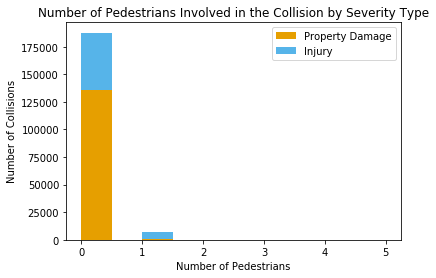

In [521]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PEDCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PEDCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 5], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Pedestrians')
plt.ylabel('Number of Collisions')
plt.title('Number of Pedestrians Involved in the Collision by Severity Type');

Let's convert it into 0 or 1 values, so either pedestrians were involved into collision or not.

In [522]:
df.loc[df['PEDCOUNT'] > 1, 'PEDCOUNT'] = 1

#### Number of bicycles involved in the collision:

In [523]:
df['PEDCYLCOUNT'].value_counts()

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

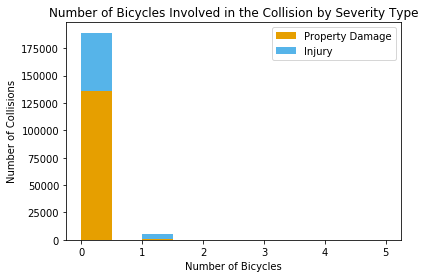

In [524]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PEDCYLCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PEDCYLCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 5], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Bicycles')
plt.ylabel('Number of Collisions')
plt.title('Number of Bicycles Involved in the Collision by Severity Type');

Same way let's convert it into 0 or 1 values, so either bicycles were involved into collision or not.

In [525]:
df.loc[df['PEDCYLCOUNT'] > 1, 'PEDCYLCOUNT'] = 1

#### Number of vehicles involved in the collision:

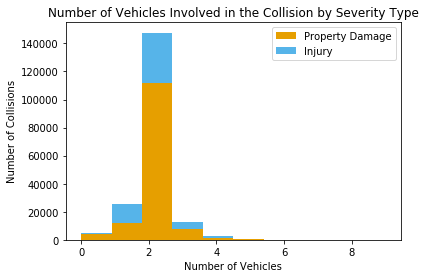

In [526]:
x1 = list(df[df['SEVERITYCODE'] == 1]['VEHCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['VEHCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 9], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Collisions')
plt.title('Number of Vehicles Involved in the Collision by Severity Type');

In [527]:
df['VEHCOUNT'].value_counts()

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

Let's assume that any value above 5 for 'Vehicle Count' will be equal 5 to remove outliers.

In [528]:
df.loc[df['VEHCOUNT'] > 5, 'VEHCOUNT'] = 5

In [529]:
df.groupby('VEHCOUNT')['SEVERITYCODE'].value_counts(normalize=True)

VEHCOUNT  SEVERITYCODE
0         1               0.758702
          2               0.241298
1         2               0.547810
          1               0.452190
2         1               0.756526
          2               0.243474
3         1               0.579554
          2               0.420446
4         1               0.555647
          2               0.444353
5         1               0.523873
          2               0.476127
Name: SEVERITYCODE, dtype: float64

### Extra features for out dataset

#### Let's see if there any specific SDOT collision codes that have high ratio of injuries and create new feature lambda function for anything that is higher than 50%. 

In [530]:
df.groupby('SDOT_COLCODE')['SEVERITYCODE'].value_counts(normalize=True).head(30) > 0.5

SDOT_COLCODE  SEVERITYCODE
0             1                True
              2               False
11            1                True
              2               False
12            1                True
              2               False
13            1                True
              2               False
14            1                True
              2               False
15            1                True
              2               False
16            1                True
              2               False
18            2                True
              1               False
21            2                True
              1               False
22            2                True
              1               False
23            2                True
              1               False
24            2                True
              1               False
25            1                True
              2               False
26            1                True
 

In [531]:
df['RSDOT_COLCODE'] = df['SDOT_COLCODE'].apply(lambda x: 1 if (x in [18, 21, 22, 23, 24, 29]) else 0)

#### Reviewing Location column to see number of collisions occured in the same place.

In [532]:
df['LOCATION'].value_counts()[:10]

BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N                          276
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB                          271
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N                                265
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST                                          254
6TH AVE AND JAMES ST                                                                    252
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST                                          239
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP                238
RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST                                   231
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP              212
WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP    212
Name: LOCATION, dtype: int64

Let's add another column with number of collisions in that location and drop Location column

In [533]:
df['NUMINCLOCATION'] = df.groupby('LOCATION')['SEVERITYCODE'].transform('size')

In [534]:
df.loc[df['NUMINCLOCATION'].isnull(), 'NUMINCLOCATION'] = 0

In [535]:
df['NUMINCLOCATION'] = df['NUMINCLOCATION'].astype(np.int64)

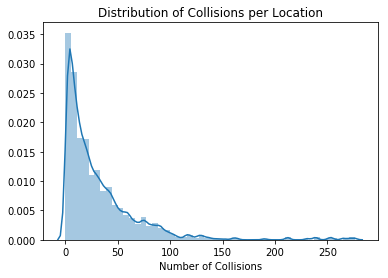

In [536]:
ax = sns.distplot(df['NUMINCLOCATION'])
ax.set(xlabel = 'Number of Collisions', title='Distribution of Collisions per Location')
plt.show()

#### Also add ratio of injuries for each location

In [537]:
v = df.groupby('LOCATION').SEVERITYCODE.value_counts().unstack()
df['LOCATIONINJRATIO'] = df.LOCATION.map(v[2] / (v[2] + v[1]))

#### Now let's assume that any location that had more than 10 collisions and injury ratio is higher than 50% will be considered as risky. 

In [560]:
del df['INJLOCATION']

In [561]:

df.loc[ (df['LOCATIONINJRATIO'] > 0.4) & (df['NUMINCLOCATION'] > 10) ,'INJLOCATION'] = 1
df['INJLOCATION'] = df['INJLOCATION'].fillna(0)

df['INJLOCATION'].value_counts()

0.0    151627
1.0     43046
Name: INJLOCATION, dtype: int64

In [562]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,HITPARKEDCAR,RPERSONCOUNT,RSDOT_COLCODE,NUMINCLOCATION,LOCATIONINJRATIO,DAYOFWEEK,INCHOUR,RHOUR,SDOT_COLCODE_STR,INJLOCATION
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,0,0,0,31,0.483871,2,14,1,11,1.0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,0,0,0,190,0.321053,2,18,1,16,0.0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,0,1,0,34,0.088235,3,10,1,14,0.0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,0,1,0,27,0.222222,4,9,1,11,0.0
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,0,0,0,28,0.285714,2,8,0,11,0.0


#### Let's see distribution of collisions across the week

In [563]:
df['DAYOFWEEK'] = df['INCDTTM'].dt.dayofweek

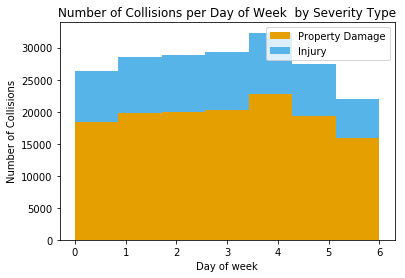

In [564]:
x1 = list(df[df['SEVERITYCODE'] == 1]['DAYOFWEEK'])
x2 = list(df[df['SEVERITYCODE'] == 2]['DAYOFWEEK'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 6], label=names, bins=7);

plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Number of Collisions')
plt.title('Number of Collisions per Day of Week  by Severity Type');

In [565]:
df.groupby('DAYOFWEEK')['SEVERITYCODE'].value_counts(normalize=True)

DAYOFWEEK  SEVERITYCODE
0          1               0.697281
           2               0.302719
1          1               0.694250
           2               0.305750
2          1               0.695705
           2               0.304295
3          1               0.692470
           2               0.307530
4          1               0.704358
           2               0.295642
5          1               0.706196
           2               0.293804
6          1               0.722022
           2               0.277978
Name: SEVERITYCODE, dtype: float64

Despite higher number of collisions on Friday, ratio between damages and injuries is constant during the week. 

#### How about distribution of collisions during the day

In [566]:
df['INCHOUR'] = df['INCDTTM'].dt.hour

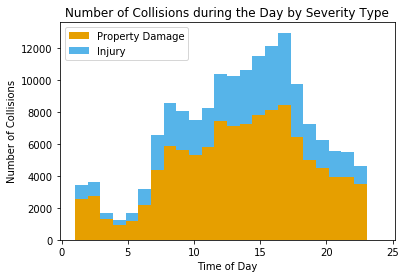

In [567]:
x1 = list(df[df['SEVERITYCODE'] == 1]['INCHOUR'])
x2 = list(df[df['SEVERITYCODE'] == 2]['INCHOUR'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[1, 24], label=names, bins=24);

plt.legend()
plt.xlabel('Time of Day')
plt.ylabel('Number of Collisions')
plt.title('Number of Collisions during the Day by Severity Type');

We see a spike of injuries during the day, so let's apply feature binarization for hours between 9:00 and 18:00. At the same time spike at midnight will not be taken into consideration as it also contains null values. 

In [568]:
df['RHOUR'] = df['INCHOUR'].apply(lambda x: 1 if (9 <= x <= 18) else 0)
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,HITPARKEDCAR,RPERSONCOUNT,RSDOT_COLCODE,NUMINCLOCATION,LOCATIONINJRATIO,DAYOFWEEK,INCHOUR,RHOUR,SDOT_COLCODE_STR,INJLOCATION
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,0,0,0,31,0.483871,2,14,1,11,1.0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,0,0,0,190,0.321053,2,18,1,16,0.0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,0,1,0,34,0.088235,3,10,1,14,0.0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,0,1,0,27,0.222222,4,9,1,11,0.0
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,0,0,0,28,0.285714,2,8,0,11,0.0


### One Hot Encoding

#### Use one hot encoding technique to conver categorical variables to binary and append them to the feature Data Frame 

In [569]:
Feature = df[['RPERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND', 
         'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR', 'RHOUR', 'RSDOT_COLCODE', 'INJLOCATION']]

In [570]:
df['SDOT_COLCODE_STR'] = df['SDOT_COLCODE'].astype(str)

In [571]:
Feature = pd.concat([Feature, pd.get_dummies(df[['ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 
                                                'ROADCOND', 'LIGHTCOND']])], axis=1)

In [572]:
Feature.head()

,RPERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,RHOUR,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,0,0,0,2,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,2,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,1,0,0,3,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,3,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


### Feature Selection

In [573]:
X = Feature
X[0:5]

,RPERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,RHOUR,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,0,0,0,2,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,2,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,1,0,0,3,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,3,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


And our target variable:

In [574]:
y = df['SEVERITYCODE']
y[0:5]

0    2
1    1
2    1
3    1
4    2
Name: SEVERITYCODE, dtype: int64

### Train Test Split

In [575]:
from sklearn.model_selection import train_test_split

#Split our dataframe into Training and test with test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136271, 61) (136271,)
Test set: (58402, 61) (58402,)


## Normalize Data

Data Standardization give data zero mean and unit variance 

In [576]:
X_train = preprocessing.StandardScaler().fit_transform(X_train)
X_train[0:1]

C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.68, -0.19, -0.17,  0.13, -0.43, -0.22, -0.16, -0.22, -0.2 ,
         0.96, -0.24, -0.53, -0.06, -1.4 ,  1.41, -0.46, -0.17, -0.1 ,
         3.62, -0.37, -0.61, -0.19, -0.46, -0.12, -0.33, -0.1 ,  1.45,
        -0.24, -0.36, -0.93, -0.03, -0.18, -0.02,  0.87, -0.05, -0.06,
        -0.41, -0.01, -0.45, -0.01, -0.02, -0.07, -0.34,  0.75, -0.08,
        -0.02, -0.02, -0.02, -0.07, -0.02, -0.34, -0.57, -0.09, -0.08,
        -0.58, -0.01, -0.11,  0.82, -0.18, -0.04, -0.33]])

In [577]:
X_test = preprocessing.StandardScaler().fit_transform(X_test)

C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Classification

Following algorithms will be used to build a model, and final report with F1-score and Jaccard Index provided:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


In [578]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import sklearn.metrics as metrics

### Decision Tree 

In [579]:
from sklearn.tree import DecisionTreeClassifier

# Train our model, make predictions and check accuracy
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train, y_train)

predTree = Tree.predict(X_test)

print("DecisionTree's Accuracy: {}".format(accuracy_score(y_test, predTree)))

DecisionTree's Accuracy: 0.7457963768364098


C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


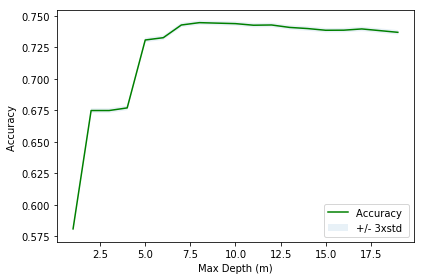

The best f1_score was with 0.744700995464284 with m=8


In [580]:
# Let's build a plot with different number of Max Depth - M

Ms = 20

mean_acc = np.zeros((Ms-1))
std_acc = np.zeros((Ms-1))
ConfustionMx = [];

for m in range(1, Ms):
    
    #Train Model and Predict  
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth = m).fit(X_train,y_train)
    yhat=dtree.predict(X_test)
    mean_acc[m-1] = f1_score(y_test, yhat, average='weighted')

    
    std_acc[m-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1, Ms),mean_acc,'g')
plt.fill_between(range(1, Ms),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth (m)')
plt.tight_layout()
plt.show()

dtree = DecisionTreeClassifier(criterion="entropy", max_depth = mean_acc.argmax()+1).fit(X_train,y_train)
yhat = dtree.predict(X_test)

Tree_f1 = f1_score(y_test, yhat, average='weighted')

print( "The best f1_score was with {} with m={}".format(mean_acc.max(), mean_acc.argmax()+1)) 

In [581]:
print( "F1-score was {} with m={}".format(Tree_f1, mean_acc.argmax()+1))
# For accuracy evaluation we will can also use Jaccard index
print("Jaccard Index: {}".format(jaccard_similarity_score(y_test, yhat)))

F1-score was 0.7446234822821988 with m=8
Jaccard Index: 0.766737440498613


              precision    recall  f1-score   support

           1       0.78      0.92      0.85     41083
           2       0.69      0.39      0.50     17319

   micro avg       0.77      0.77      0.77     58402
   macro avg       0.73      0.66      0.67     58402
weighted avg       0.75      0.77      0.74     58402

Confusion matrix, without normalization
[[37979  3104]
 [10519  6800]]


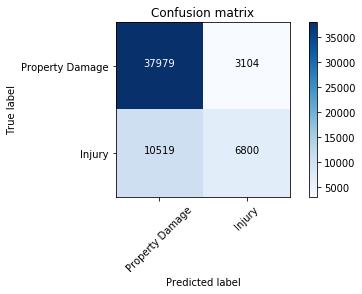

In [582]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Let's evaluate our model and build confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, yhat, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')

#### As we see from confusion matrix predictions of injuries, which is more important than prediction of collisions, are quite poor with imbalanced dataset. Let's see if other algorithms can perform better. 

### Logistic Regression

In [583]:
from sklearn.linear_model import LogisticRegression

In [584]:
from sklearn.model_selection import GridSearchCV

In [585]:
parameters1= [{'C': [0.001, 0.01, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}]

In [586]:
LR = LogisticRegression()

f1 = metrics.make_scorer(f1_score, average='macro')

In [587]:
Grid1 = GridSearchCV(LR, parameters1, cv=4, scoring=f1)

In [588]:
Grid1.fit(X_train,y_train)

C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\dvasilyev\AppData\Local\Continu

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [589]:
BestRR=Grid1.best_estimator_
BestRR

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [590]:
BestRR.score(X_test, y_test)

0.7652648881887607

In [593]:
# Initialize and train Logistic Regression model
LR = LogisticRegression(C=1, solver='lbfgs').fit(X_train,y_train)

# Predict values
predLR = LR.predict(X_test)

# Return estimates for all classes ordered by the label of classes
probLR = LR.predict_proba(X_test)

predLR[0:5]

array([1, 1, 1, 2, 1], dtype=int64)

              precision    recall  f1-score   support

           1       0.78      0.93      0.85     41083
           2       0.69      0.37      0.48     17319

   micro avg       0.77      0.77      0.77     58402
   macro avg       0.74      0.65      0.67     58402
weighted avg       0.75      0.77      0.74     58402

Confusion matrix, without normalization
[[38253  2830]
 [10879  6440]]


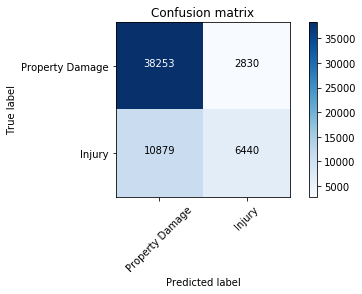

In [594]:
cnf_matrix = confusion_matrix(y_test, predLR, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, predLR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')

In [595]:
# For accuracy evaluation we will use Jaccard index
print("Jaccard Index: {}".format(jaccard_similarity_score(y_test, predLR)))
print("F1-Score: {}".format(metrics.f1_score(y_test, predLR, average='weighted')))

Jaccard Index: 0.7652648881887607
F1-Score: 0.7402070354943879


#### Little better, however dataset has to be balanced in order to increase recall for injuries.

## Undersampling majority class

#### Before we proceed with balancing let's review our target classes 

Text(0.5, 1.0, 'Number of Collisions Per Severity Code')

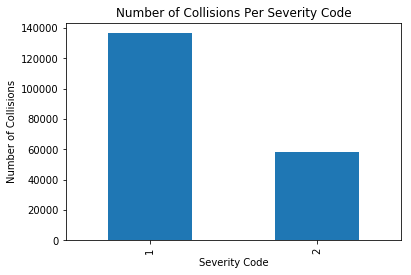

In [596]:
ax = df['SEVERITYCODE'].value_counts().plot(kind = 'bar')

ax.set_xlabel('Severity Code')
ax.set_ylabel('Number of Collisions')
ax.set_title('Number of Collisions Per Severity Code')

In [597]:
XX = pd.DataFrame(X_train).reset_index(drop=True)

In [598]:
yy = pd.DataFrame(y_train).reset_index(drop=True)

In [599]:
X = pd.concat([XX, yy], axis=1)

In [600]:
damage = X[X.SEVERITYCODE == 1]
injury = X[X.SEVERITYCODE == 2]

unsamples = round(len(injury))

In [601]:
from sklearn.utils import resample
damage_downsampled = resample(damage,
                                replace = False, # sample without replacement
                                n_samples = unsamples, # match minority n
                                random_state = 27)

In [602]:
downsampled = pd.concat([damage_downsampled, injury])

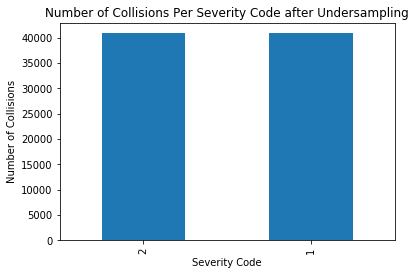

In [603]:
ax = downsampled['SEVERITYCODE'].value_counts().plot(kind = 'bar')

ax.set_xlabel('Severity Code')
ax.set_ylabel('Number of Collisions')
ax.set_title('Number of Collisions Per Severity Code after Undersampling');

In [604]:
y_train_ds = downsampled.SEVERITYCODE
X_train_ds = downsampled.drop('SEVERITYCODE', axis=1)

In [605]:
undersampled = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_ds,y_train_ds)

In [606]:
undersampled_pred = undersampled.predict(X_test)

In [607]:
f1_score(y_test, undersampled_pred, average='weighted')

0.718163401418064

In [608]:
jaccard_similarity_score(y_test, undersampled_pred)

0.7064312865997739

              precision    recall  f1-score   support

           1       0.86      0.69      0.77     41083
           2       0.50      0.74      0.60     17319

   micro avg       0.71      0.71      0.71     58402
   macro avg       0.68      0.72      0.68     58402
weighted avg       0.76      0.71      0.72     58402

Confusion matrix, without normalization
[[28490 12593]
 [ 4552 12767]]


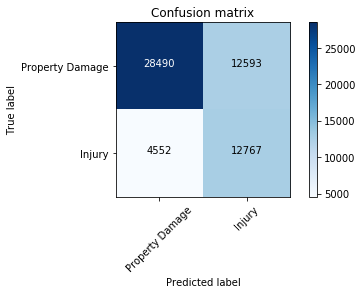

In [609]:
cnf_matrix = confusion_matrix(y_test, undersampled_pred, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, undersampled_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')

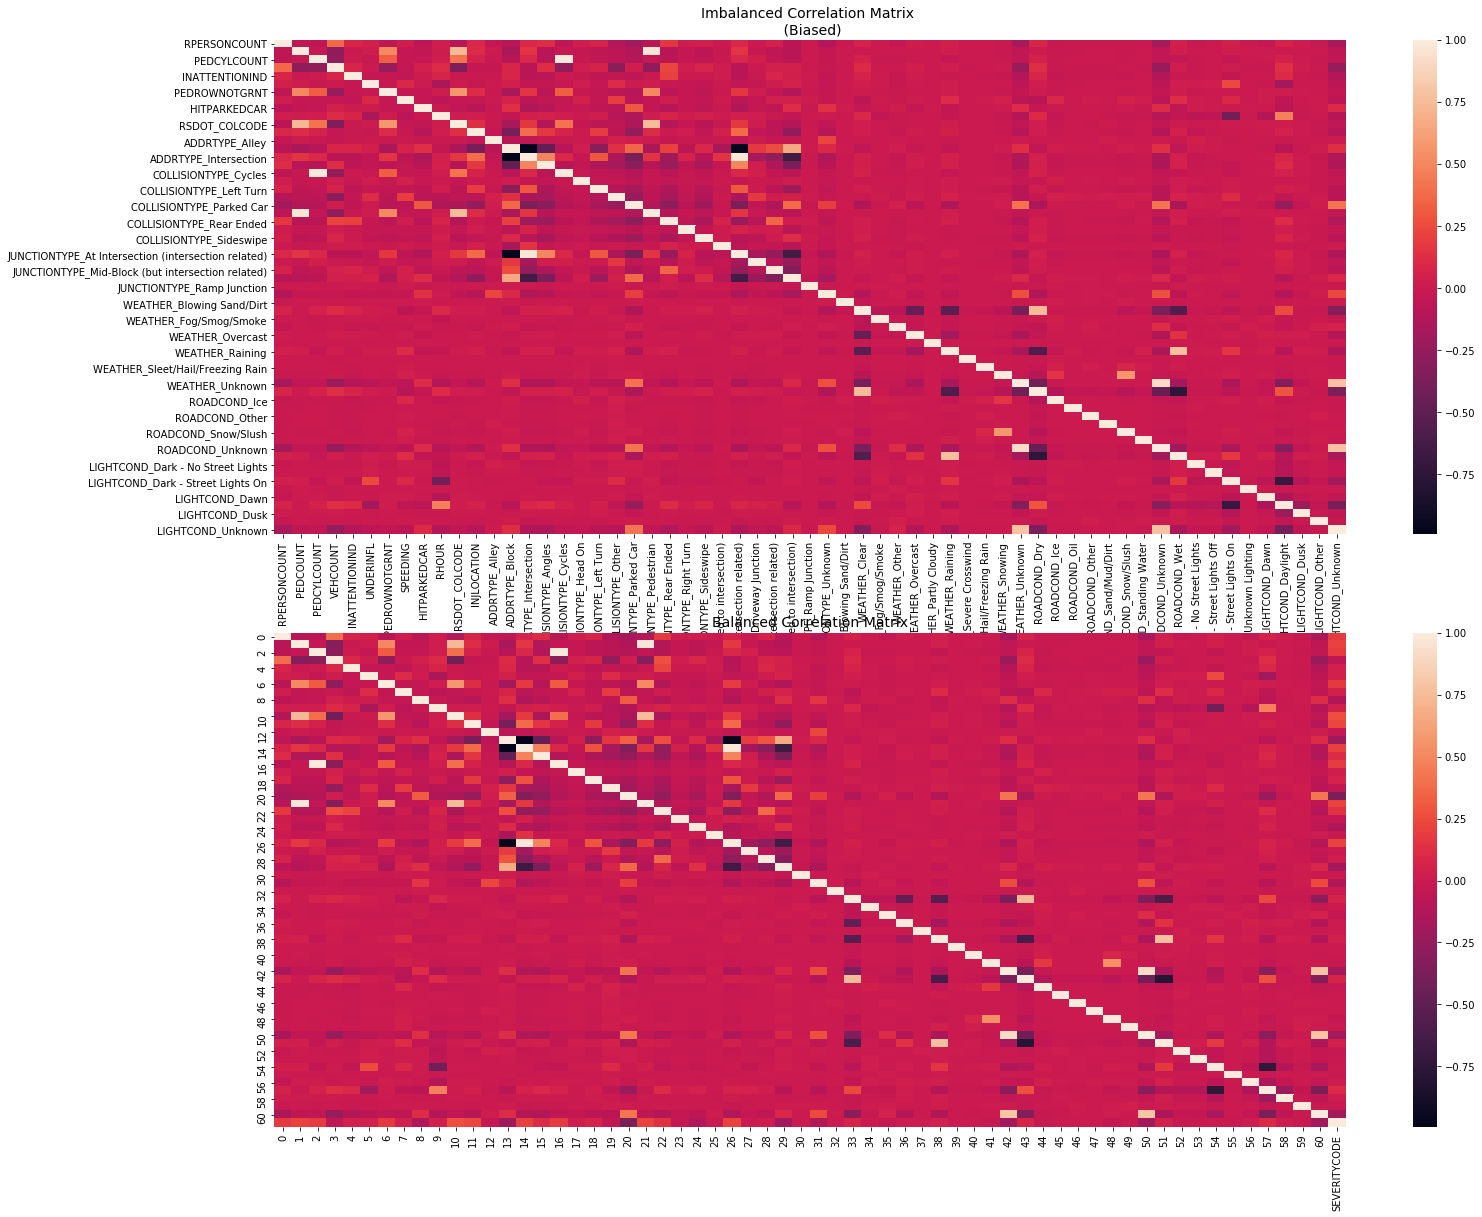

In [627]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Imbalanced DataFrame
corr = X.corr()
sns.heatmap(corr, annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (Biased)", fontsize=14)

# Balanced DataFrame
bal_corr = downsampled.corr()
sns.heatmap(bal_corr, annot_kws={'size':20}, ax=ax2)
ax2.set_title('Balanced Correlation Matrix', fontsize=14)
plt.show()

In [628]:
bal_corr.SEVERITYCODE

0               1.780899e-01
1               2.207475e-01
2               1.899975e-01
3              -5.802356e-02
4               4.899572e-02
5               4.891348e-02
6               1.807506e-01
7               4.262987e-02
8              -1.310587e-01
9               4.242867e-02
10              2.668584e-01
11              2.341086e-01
12             -3.221893e-02
13             -2.083751e-01
14              2.124088e-01
15              1.072930e-01
16              1.886130e-01
17              2.789140e-02
18              5.809502e-02
19             -3.703585e-02
20             -3.687124e-01
21              2.145854e-01
22              1.381912e-01
23             -2.317381e-02
24             -1.337944e-01
25             -4.643861e-03
26              2.158090e-01
27              4.809908e-04
28              2.087785e-02
29             -1.847708e-01
                    ...     
32              1.251692e-16
33              6.645878e-02
34              2.945563e-03
35            

## Oversampling minority Class

In [610]:
upsamples = round(len(damage) * 0.7)

In [611]:
injury_upsampled = resample(injury, replace=True, n_samples=upsamples, random_state=27)

In [612]:
upsampled = pd.concat([damage, injury_upsampled])

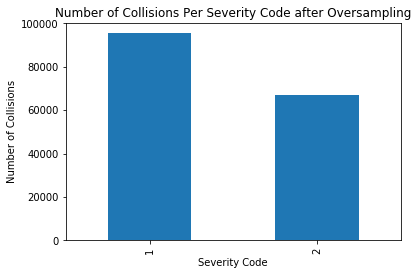

In [613]:
ax = upsampled['SEVERITYCODE'].value_counts().plot(kind = 'bar')

ax.set_xlabel('Severity Code')
ax.set_ylabel('Number of Collisions')
ax.set_title('Number of Collisions Per Severity Code after Oversampling');

In [614]:
y_train_up = upsampled.SEVERITYCODE
X_train_up = upsampled.drop('SEVERITYCODE', axis=1)

In [615]:
upsampledLR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train_up,y_train_up)

upsampled_pred = upsampledLR.predict(X_test)

In [616]:
f1_score(y_test, upsampled_pred, average = 'weighted')

0.7435635283309283

In [617]:
recall_score(y_test, upsampled_pred)

0.7834627461480418

In [618]:
jaccard_similarity_score(y_test, upsampled_pred)

0.7388103147152495

              precision    recall  f1-score   support

           1       0.84      0.78      0.81     41083
           2       0.55      0.63      0.59     17319

   micro avg       0.74      0.74      0.74     58402
   macro avg       0.69      0.71      0.70     58402
weighted avg       0.75      0.74      0.74     58402

Confusion matrix, without normalization
[[32187  8896]
 [ 6358 10961]]


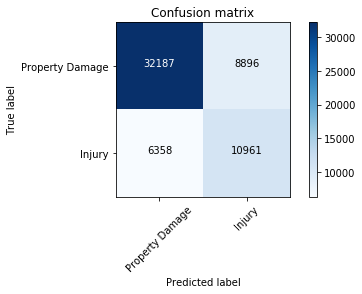

In [619]:
cnf_matrix = confusion_matrix(y_test, upsampled_pred, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, upsampled_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')

## Synthetic Minority Oversampling Technique

In [620]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [621]:
k = 7

sm = SMOTE(sampling_strategy=0.7, k_neighbors=k, random_state=4, n_jobs = 7) 

In [622]:
X = Feature
y = df['SEVERITYCODE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dvasilyev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [623]:
smoteLR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_sm,y_train_sm)

smote_pred = smoteLR.predict(X_test)

In [624]:
f1_score(y_test, smote_pred, average='weighted')

0.7433612146507639

In [625]:
recall_score(y_test, smote_pred)

0.7857021152301439

              precision    recall  f1-score   support

           1       0.83      0.79      0.81     41083
           2       0.55      0.63      0.59     17319

   micro avg       0.74      0.74      0.74     58402
   macro avg       0.69      0.71      0.70     58402
weighted avg       0.75      0.74      0.74     58402

Confusion matrix, without normalization
[[32279  8804]
 [ 6445 10874]]


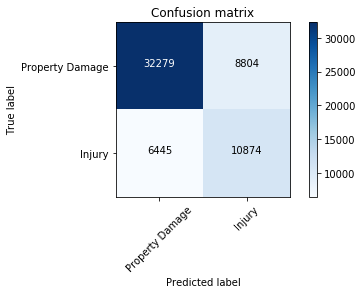

In [626]:
cnf_matrix = confusion_matrix(y_test, smote_pred, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, smote_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')